In [6]:
import numpy as np 
import pandas as pd 
import os
from scipy.io import wavfile
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import python_speech_features
import datetime


In [ ]:
print(datetime.datetime.now())
s = {'left','yes','no','off','on'}
audio = []
label_y = []
counta = 0
countb = 0

for folder in os.listdir("../../a/train/"):
        for filename in os.listdir("../../a/train/"+folder):
                rate , audio_file = wavfile.read("../../a/train/"+folder+"/"+filename)
                if(len(audio_file) != 16000):
                    continue
                audio.append(python_speech_features.base.mfcc(aaa, winlen=0.040, winstep=0.020, numcep=40, nfilt = 40, nfft = 640))
                if (folder in s):
                    counta += 1
                    label_y.append(folder)
                else:
                    label_y.append("unknown")
                    countb += 1
print(datetime.datetime.now())

In [2]:
#TPU only
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

In [3]:
#TPU only
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
label_y = np.array(label_y)
audio = np.array(audio,dtype='float32')
np.save("audio",audio)
np.save("label_y",label_y)

In [9]:
label_y = np.load("../input/label_y.npy")
audio = np.load("../input/audio.npy")


In [10]:
le = LabelEncoder()
label  = to_categorical(le.fit_transform(label_y))

In [11]:
se = set()
for i in range(len(label_y)):
    if(label_y[i] not in se):
        se.add(label_y[i])
        print(y[i],label_y[i])

[0. 0. 0. 0. 1. 0.] unknown
[0. 0. 0. 0. 0. 1.] yes
[1. 0. 0. 0. 0. 0.] left
[0. 1. 0. 0. 0. 0.] no
[0. 0. 1. 0. 0. 0.] off
[0. 0. 0. 1. 0. 0.] on


In [12]:
audio_train, audio_test, label_train, label_test = train_test_split(audio, label, test_size=0.2, random_state = 63)


In [21]:

    model = Sequential()
    model.add(tf.keras.layers.Conv2D(16,(3,3),input_shape =(49,40,1),activation='relu',padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.SeparableConv2D(8,(7,7),activation='relu'))
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2,2),strides = 2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(6,activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [ ]:
history = model.fit(audio_train, label_train, batch_size=64, epochs=50,callbacks = [tf.keras.callbacks.ModelCheckpoint("./model/", monitor='val_loss')],
validation_data=(audio_test, label_test), verbose=1)

In [22]:
history = model.fit(audio_train, label_train, batch_size=64, epochs=50,callbacks = [tf.keras.callbacks.ModelCheckpoint("./model/", monitor='val_loss')],validation_data=(audio_test, label_test), verbose=1)

Train on 73536 samples, validate on 18390 samples
Epoch 1/50
73536/73536 [==============================] - 24s 332us/sample - loss: 0.6282 - accuracy: 0.8113 - val_loss: 0.4966 - val_accuracy: 0.8408
Epoch 2/50
73536/73536 [==============================] - 14s 197us/sample - loss: 0.4764 - accuracy: 0.8456 - val_loss: 0.4243 - val_accuracy: 0.8620
Epoch 3/50
73536/73536 [==============================] - 14s 190us/sample - loss: 0.4187 - accuracy: 0.8616 - val_loss: 0.3667 - val_accuracy: 0.8780
Epoch 4/50
73536/73536 [==============================] - 14s 194us/sample - loss: 0.3817 - accuracy: 0.8720 - val_loss: 0.3196 - val_accuracy: 0.8941
Epoch 5/50
73536/73536 [==============================] - 16s 214us/sample - loss: 0.3550 - accuracy: 0.8799 - val_loss: 0.3175 - val_accuracy: 0.8958
Epoch 6/50
73536/73536 [==============================] - 14s 190us/sample - loss: 0.3378 - accuracy: 0.8861 - val_loss: 0.2969 - val_accuracy: 0.9036
Epoch 7/50
73536/73536 [====================

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 40, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 49, 40, 16)        64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 40, 16)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 43, 34, 8)         920       
_________________________________________________________________
average_pooling2d_2 (Average (None, 21, 17, 8)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 17, 8)         32        
_________________________________________________________________
dropout_5 (Dropout)          (None, 21, 17, 8)        

In [ ]:
model.save("model1")

In [ ]:
print(history.history)

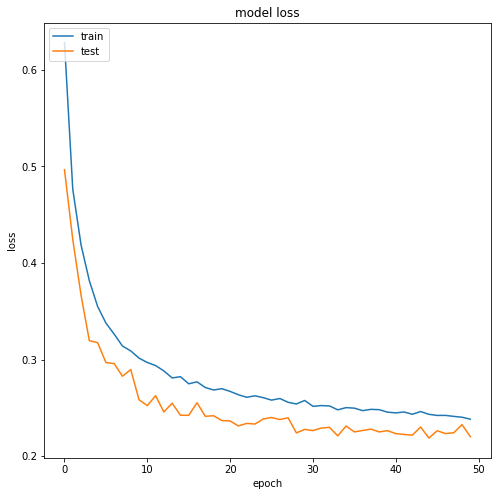

In [24]:

plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss')

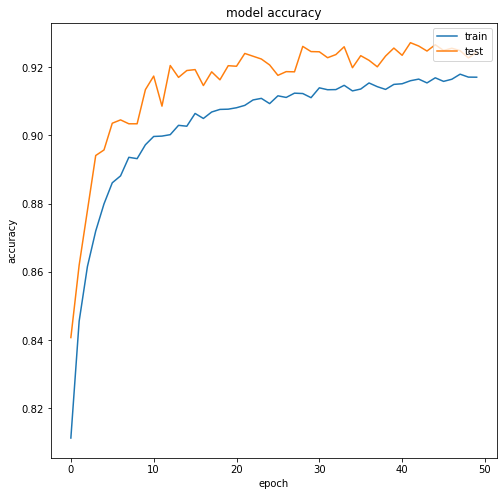

In [33]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy')

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [27]:
open("converted_model.tflite", "wb").write(tflite_model)


25376

In [28]:
y = model.predict(audio_train)
Y_pred_classes = np.argmax(y,axis=1) 
Y_true = np.argmax(label_train,axis=1)

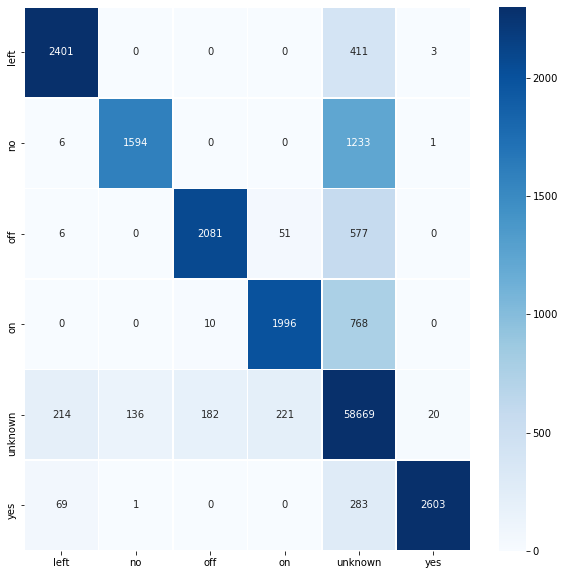

In [32]:


cm = confusion_matrix(Y_true, Y_pred_classes)
df = pd.DataFrame(cm,index=['left', 'no', 'off', 'on','unknown', 'yes'],columns=['left', 'no', 'off', 'on','unknown','yes'])
plt.figure(figsize=(10,10))
sns.heatmap(df,annot=True,fmt="d",linewidths=.5,cmap="Blues",vmin = 0, vmax = 2300 )
plt.savefig('confusion_matrix')